In [2]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2013-06-28,CI,2013-06-28,72.41,73.13,72.290,72.49,69.6041,1865400,2.067169e+10
2009-05-11,MCHP,2009-05-11,21.17,21.67,20.950,21.04,7.1008,11525612,7.866465e+09
2010-08-19,DVN,2010-08-19,63.12,63.50,62.770,63.00,47.8036,5619680,2.806232e+10
2012-02-29,GHC,2012-02-29,393.90,398.69,393.900,393.90,204.8562,32969,3.051596e+09
2019-10-08,ABC,2019-10-08,81.26,81.87,80.125,80.17,76.0285,1345012,1.716440e+10


In [4]:

def slope_price( close, length=None, as_angle=None, to_degrees=None, vertical=None, offset=None, **kwargs):

    length = int(length) if length and length > 0 else 1
    as_angle = True if isinstance(as_angle, bool) else False
    to_degrees = True if isinstance(to_degrees, bool) else False
    offset   = int(offset) if offset else 0

    if close is None: return

    slope = close.diff(length) / length
    if as_angle:
        slope = slope.apply(np.arctan)
        if to_degrees:
            slope *= 180 / np.pi

    if offset != 0:
        slope = slope.shift(offset)


    if "fillna" in kwargs:
        slope.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        slope.fillna(method=kwargs["fill_method"], inplace=True)


    return slope

In [5]:
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = slope_price(df_ticker['close'].ewm(alpha=0.5).mean(),length=5)
        results[ticker] = metrics
    except :
        print(ticker)

100%|██████████| 866/866 [00:05<00:00, 170.81it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_21824\1238249581.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe                      1.6
Daily turnover (%)          0.6
Average daily pnl (bps)     2.6
dtype: float64

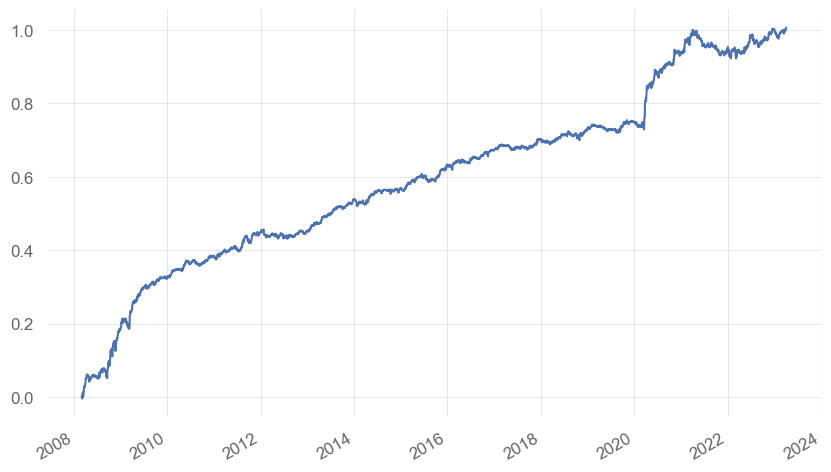

In [8]:
signal = pd.concat(results,axis=1).reindex_like(P).ffill()
signal = signal[P].abs().rolling(21).max() * np.sign(signal[P])
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Daily turnover (%)':turnover,'Average daily pnl (bps) ':PNL.mean()*1e4}).round(1)

<Axes: >

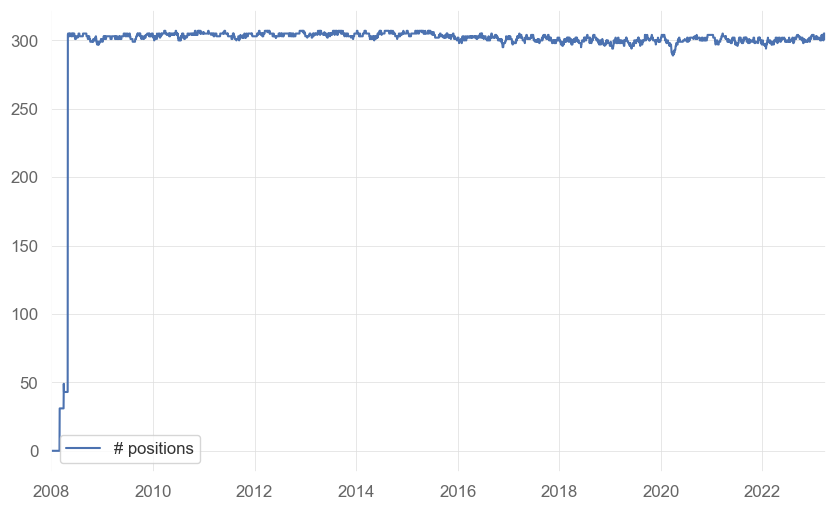

In [6]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

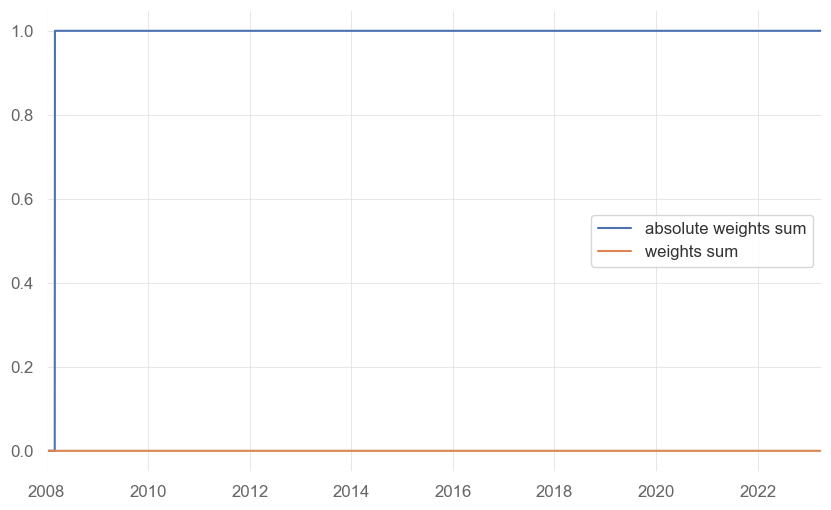

In [7]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)